In [1]:
import os
import cv2
import json
import numpy as np
import pandas
import skimage
import shapefile
import matplotlib.pyplot as plt

import time
from PIL import Image as pil_image

from keras.applications import vgg16
from keras import backend as K
from keras import layers
from keras.preprocessing.image import save_img
from keras.models import load_model

import tensorflow as tf

import modules

Using TensorFlow backend.
/home/BenChoi/miniconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/BenChoi/miniconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/BenChoi/miniconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/BenChoi/miniconda3/e

In [202]:
#resnet = resnet_v2.ResNet50V2(include_top=True, weights='imagenet')

with tf.device('device:GPU:1'):
    
    #model = load_model('data/checkpoints/model.hdf5')
    model = load_model('data/clsw5/checkpoints/model.hdf5')
    LAYER_NAME = 'block1_conv1'

    print('Model loaded.')

    print(model.summary())

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0      

In [3]:
def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()

# Learns input image that maximizes filter activation

def visualize_layer_filter(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_index=0):
    
    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):

        # Loss function that maximizes the activation of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])
        
        # NOTE: Replacing the below with the output index of the desired class (e.g. '2' for 'two-track')
        # can allow you to generate visualization of filters that maximize the activation for the given
        # output class (e.g. will generate an image that looks like what the model thinks is a two-track road)
        
        # output_index = 5
        # loss = K.mean(model.output[:, output_index])

        grads = normalize(K.gradients(loss, input_img)[0])
        
        # returns the loss and grads given input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = np.expand_dims(
                process_image(img, input_img_data[0]), 0)

        img = deprocess_image(input_img_data[0])

        return img, loss_value

    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    img_loss = _generate_filter_image(input_img, output_layer.output, filter_index)
    return img_loss


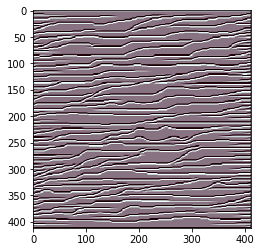

In [8]:
with tf.device('device:GPU:1'):
    # Example: Visualization of input image that maximizes activation of filter #5 in conv1_conv layer (as defined by LAYER_NAME above)
    plt.imshow(visualize_layer_filter(model, 'block5_conv1', filter_index=0)[0])

In [ ]:
# Example plot of several other filters from the first CONV layer
plt.imshow(cv2.imread('vgg_conv1_conv_5x5.png'))

In [9]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from matplotlib import pyplot

In [111]:
# Generates activation map of each filter in 'layer_name' applied to 'img'

def show_activation_map(img, model, layer_name, preprocess_fn, square_dim):

    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    model = Model(inputs=model.inputs, outputs=layer_dict[layer_name].output)

    img = img_to_array(img)
    img = expand_dims(img, axis=0)
    img = preprocess_fn(img)
    feature_maps = model.predict(img)

    print(feature_maps.shape)
    
    feature_means = np.mean(feature_maps, axis=(0,1,2))
    
#     img = np.clip(img, 0, 1)
#     pyplot.imshow(img[0, :,:,:])
# #     plt.imshow(cv2.cvtColor(img[0, :,:,:], cv2.COLOR_BGR2RGB))
#     pyplot.show()
    
#     ix = 1
#     for _ in range(square_dim):
#         for _ in range(square_dim):
#             ax = pyplot.subplot(square_dim, square_dim, ix)
#             ax.set_xticks([])
#             ax.set_yticks([])
#             pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='magma')
#             ix += 1
#     pyplot.show()
    return feature_means
    
    

[24 23 22 16 11  9  8  7  6  6  4  3  2  2  2  2  2  1  1  1  1  1  1  1
  1  1  1  1]


Text(0, 0.5, 'Frequency')

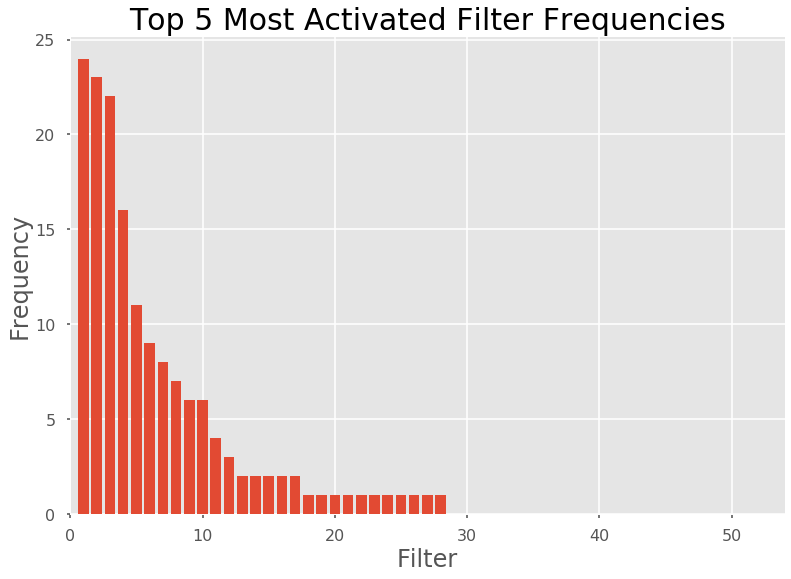

In [204]:
top_5_freq = np.flip(np.sort(np.unique(top_5, return_counts=True)[1]))
print(top_5_freq)
plt.bar(range(1, 1 + top_5_freq.shape[0]), top_5_freq)
plt.xlim(0, 1 + 53)
plt.title('Top 5 Most Activated Filter Frequencies')
plt.xlabel('Filter')
plt.ylabel('Frequency')

(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
(1, 224, 224, 64)
(64,)
[21 19 17 16 15 15 14 13  4  4  3  3  3  2  2  2  1  1  1  1  1  1  1]


Text(0, 0.5, 'Frequency')

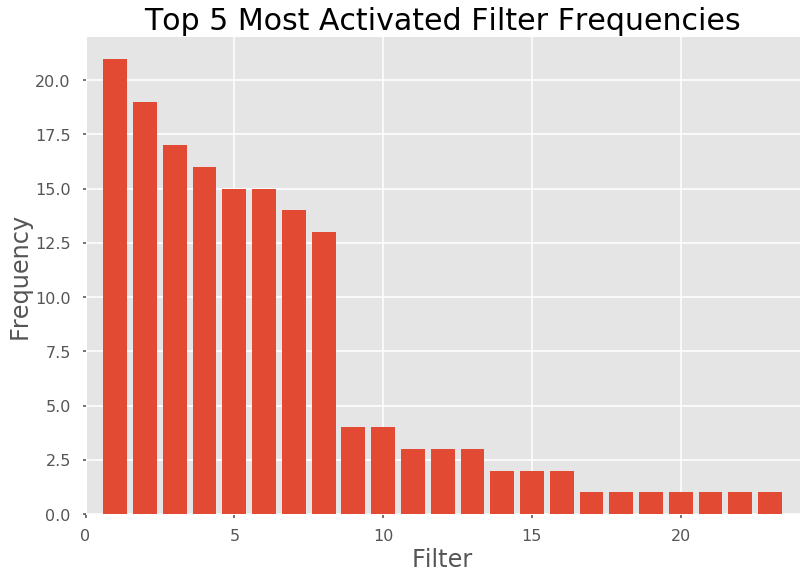

In [206]:
# plt.imshow(cv2.imread('local_images/kenya/408900_kenya_resized.jpg'))
# plt.show()
# img = load_img('local_images/kenya/408900_kenya_resized.jpg', target_size=(224, 224))

# plt.imshow(cv2.imread('local_images/kenya/42552_kenya_resized.jpg'))
# plt.show()
img = load_img('local_images/kenya/42552_kenya_resized.jpg', target_size=(224, 224))


#345677
# Note: 'square_dim' can be up to the square root of the number of filters in the layer

# First CONV layer activation map
#hist_1 = show_activation_map(img, model, 'block1_conv1', preprocess_input, square_dim=4)

# Class activation map
#vgg = vgg16.VGG16(include_top=True, weights='imagenet')
hist_2 = show_activation_map(img, model, 'block1_conv1', preprocess_input, square_dim=16)

top_5 = []

for name in major_df['fname']:
    img = load_img('local_images/kenya/' + name, target_size=(224, 224))
    hist_2 = show_activation_map(img, model, 'block1_conv1', preprocess_input, square_dim=16)
    top_5.extend(hist_2.argsort()[-5:][::-1])

# print(top_5)
# print(np.argmax(hist_2))
# print(hist_2.argsort()[-5:][::-1])

top_5_freq = np.flip(np.sort(np.unique(top_5, return_counts=True)[1]))
print(top_5_freq)
plt.bar(range(1, 1 + top_5_freq.shape[0]), top_5_freq)
plt.xlim(0, 1 + top_5_freq.shape[0])
plt.title('Top 5 Most Activated Filter Frequencies')
plt.xlabel('Filter')
plt.ylabel('Frequency')


# plt.rc('axes', labelsize=24)
# plt.rc('axes', titlesize=30)
# plt.bar(range(1,513), hist_2, color='g')
# plt.ylim(0, max(hist_2) + 0.1 * max(hist_2))
# plt.xlim(1, 512)
# plt.title("Mean Activations of Last Conv Layer")
# plt.xlabel('Filter')
# plt.ylabel('Mean Activation')

# # pyplot.artist.setp(artist, color="black")
# plt.show()

In [144]:
import matplotlib.style as style
style.available
style.use('seaborn-poster')
style.use('ggplot')

In [55]:
# Generates test set indices for failure case analysis

def get_failure_indices(X_test, y_test):
    return np.nonzero(model.predict_class(X_test).reshape((-1,)) != y_test)

In [19]:
import modules

config = modules.run.load_config("cls", tag="w5")
dg = modules.data.DatasetGenerator(config=config)
dg._setup("kenya")
sample_filenames = dg.sample("kenya", N=32, validate=False)
formatted_filenames = ["{}_kenya_resized.jpg".format(sample_filename.split(".")[0].split("_")[1]) for sample_filename, _ in list(zip(*sample_filenames))]

In [76]:
ids = [fname.split("_")[0] for fname in formatted_filenames]
test_df = dg.dataframes['kenya'][dg.dataframes["kenya"]["id"].isin(ids)][["class"]]
test_df["fname"] = formatted_filenames
test_df["fname"] = formatted_filenames

major_df = test_df[test_df['class']=='major']
minor_df = test_df[test_df['class']=='minor']
two_df = test_df[test_df['class']=='two-track']

all_df = pandas.concat([major_df, minor_df, two_df])
print(all_df[0:32])
print(major_df)

        class                     fname
index                                  
67      major  461045_kenya_resized.jpg
103     major  408900_kenya_resized.jpg
168     major       2_kenya_resized.jpg
338     major   32967_kenya_resized.jpg
492     major   42552_kenya_resized.jpg
1224    major  300151_kenya_resized.jpg
1496    major   35057_kenya_resized.jpg
1726    major  450369_kenya_resized.jpg
2098    major   44955_kenya_resized.jpg
2352    major  444981_kenya_resized.jpg
2368    major   45070_kenya_resized.jpg
2450    major   46495_kenya_resized.jpg
2712    major   14079_kenya_resized.jpg
2882    major  291288_kenya_resized.jpg
3061    major   46463_kenya_resized.jpg
3272    major  218946_kenya_resized.jpg
3382    major   44839_kenya_resized.jpg
3443    major  470582_kenya_resized.jpg
3446    major   17630_kenya_resized.jpg
3815    major  452304_kenya_resized.jpg
3829    major   43439_kenya_resized.jpg
4381    major   19666_kenya_resized.jpg
4628    major   42586_kenya_resized.jpg


Found 96 validated image filenames belonging to 3 classes.
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 2 0 2 1 1 1 1 1 2 1 2 2 2 0 1 2 1 1 1 1 2 1 1 0 2 2 1 2 2 2 1 2 2 2 1 2 2
 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 1 1 1 2 2 2 2]


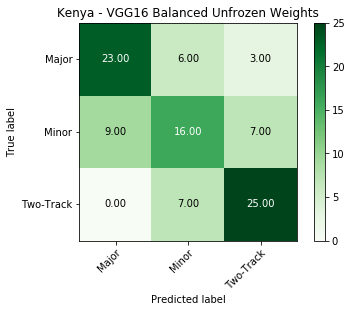

In [96]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

with tf.device('device:GPU:1'):
    df_to_analyze = test_df
    test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input, 
                                             horizontal_flip=True, 
                                             vertical_flip=True,)
    #                                          rotation_range=180,
    #                                          brightness_range=[0.0, 2.0],
    #                                          zoom_range=[0.8, 1.0],
    #                                          shear_range=.2,
    #                                          channel_shift_range=.2,
    #                                          width_shift_range=.2,
    #                                          height_shift_range=.2,
    #                                          fill_mode='nearest')
    test_generator = test_datagen.flow_from_dataframe(
            dataframe=df_to_analyze,
            directory='local_images/kenya/',
            x_col="fname",
            y_col="class",
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical',
            shuffle=False)
    
    print(test_generator.classes)
    
    predictions = model.predict_generator(test_generator, steps=3)
#     predictions = model.predict_generator(test_generator, steps=1)
    print(np.argmax(predictions, axis=1))
    
    y_true = test_generator.classes
    y_pred = np.argmax(predictions, axis=1)
    
    classes = ['Major', 'Minor', 'Two-Track']
    
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Kenya - VGG16 Balanced Unfrozen Weights',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    fig.show()
    plt.ylim([2.5, -0.5])
    
#     print(df_to_analyze[np.argmax(predictions, axis=1) != 0]['fname'])
    
#     for idx, name in enumerate(df_to_analyze['fname']):
#         plt.imshow(cv2.imread('local_images/kenya/' + name))
#         plt.title(str(np.argmax(predictions, axis=1)[idx]))
#         plt.show()
#     img = cv2.imread('345677_kenya_resized.jpg')
#     img = img_to_array(img)
#     img = expand_dims(img, axis=0)
#     print(model.predict(preprocess_input(img)))